In [14]:
import os
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [10]:
# -----------------------------
# Parameters
# -----------------------------
years = [2013, 2014, 2015, 2016, 2017, 2019]
input_dir = "data_by_year"
output_dir = "results_by_year"
os.makedirs(output_dir, exist_ok=True)

kmeans_clusters = 5
plot_sample_size = 10000  # number of points to plot (speed)


Processing year 2013...


c:\Users\eadun\miniconda3\envs\cs506_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


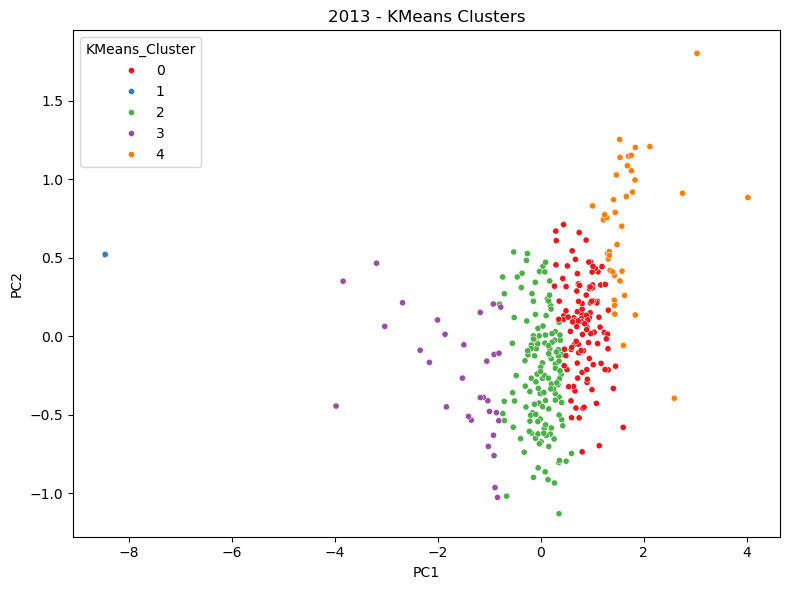

Year 2013 done: PCA + KMeans clusters saved.

Processing year 2014...


c:\Users\eadun\miniconda3\envs\cs506_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


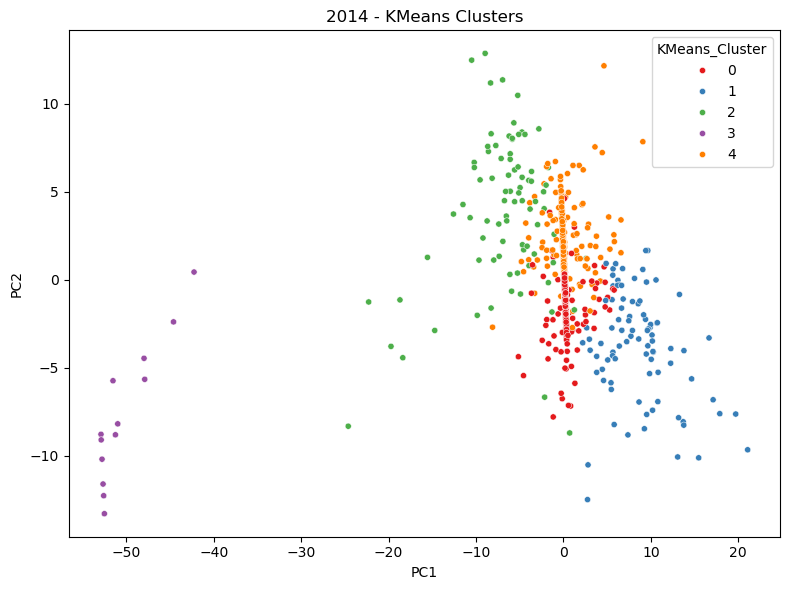

Year 2014 done: PCA + KMeans clusters saved.

Processing year 2015...


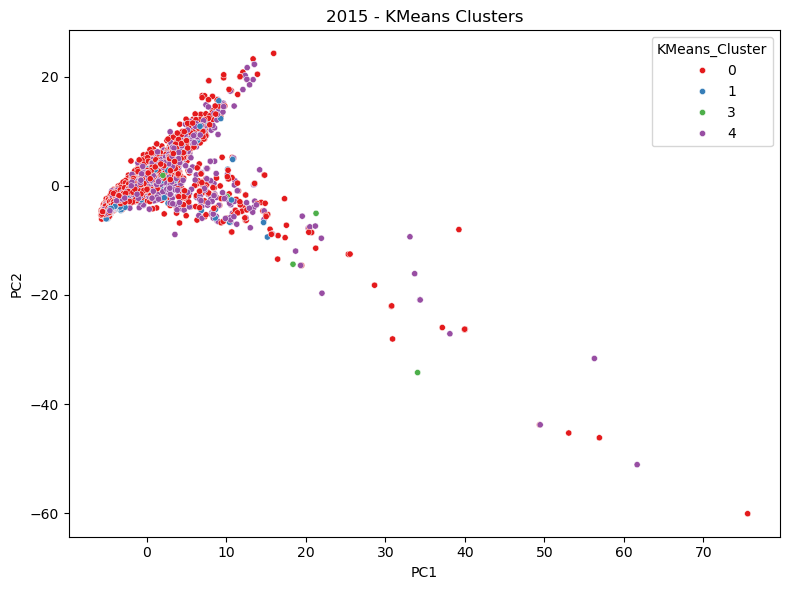

Year 2015 done: PCA + KMeans clusters saved.

Processing year 2016...


c:\Users\eadun\miniconda3\envs\cs506_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


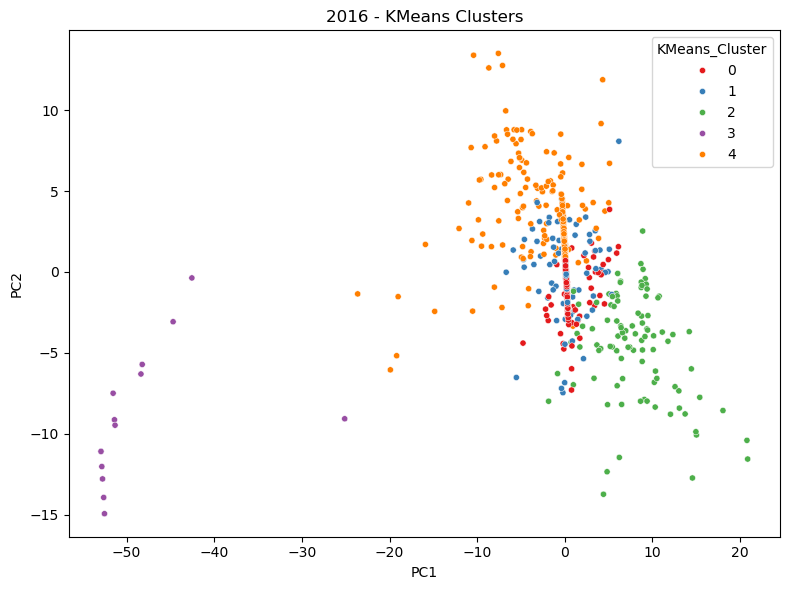

Year 2016 done: PCA + KMeans clusters saved.

Processing year 2017...


c:\Users\eadun\miniconda3\envs\cs506_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=13.
  warnings.warn(


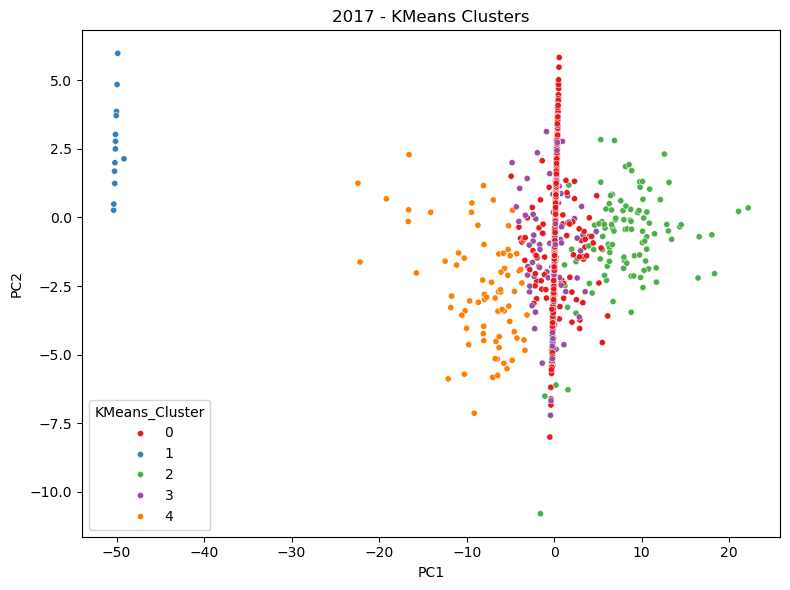

c:\Users\eadun\miniconda3\envs\cs506_env\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Year 2017 done: PCA + KMeans clusters saved.

Processing year 2019...


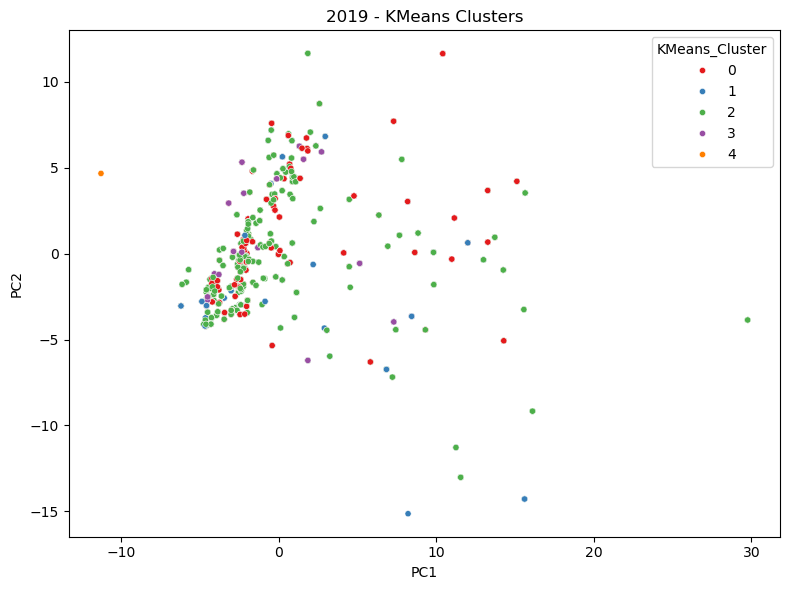

Year 2019 done: PCA + KMeans clusters saved.


In [11]:

# -----------------------------
# Main loop
# -----------------------------
for year in years:
    print(f"\nProcessing year {year}...")
    
    # 1️⃣ Load data
    file_path = os.path.join(input_dir, f"merged_data_{year}.csv")
    df = pd.read_csv(file_path, dtype={'CountyFIPS': str})
    
    # 2️⃣ Remove fully empty columns
    df_clean = df.dropna(axis=1, how='all')
    
    # Keep numeric columns
    numeric_cols = df_clean.select_dtypes(include='number').columns
    df_numeric = df_clean[numeric_cols]
    
    # 3️⃣ Impute missing values (median)
    imputer = SimpleImputer(strategy='median')
    X_imputed = imputer.fit_transform(df_numeric)
    
    # 4️⃣ Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imputed)
    
    # 5️⃣ PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    pca_df['CountyFIPS'] = df_clean['CountyFIPS'].values
    pca_df['Survey_Year'] = year
    #pca_df.to_csv(os.path.join(output_dir, f"pca_{year}.csv"), index=False)
    
    # 6️⃣ KMeans clustering
    kmeans = KMeans(n_clusters=kmeans_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    clusters_df = pd.DataFrame({
        'CountyFIPS': df_clean['CountyFIPS'].values,
        'Survey_Year': year,
        'KMeans_Cluster': kmeans_labels
    })
    #clusters_df.to_csv(os.path.join(output_dir, f"clusters_{year}.csv"), index=False)
    
    # 7️⃣ Visualization (downsample for speed)
    plot_df = pca_df.merge(clusters_df, on=['CountyFIPS', 'Survey_Year'])
    plot_df_sample = plot_df.sample(min(len(plot_df), plot_sample_size), random_state=42)
    
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=plot_df_sample, x='PC1', y='PC2', hue='KMeans_Cluster', palette='Set1', s=20)
    plt.title(f"{year} - KMeans Clusters")
    plt.tight_layout()
    #plt.savefig(os.path.join(output_dir, f"clusters_plot_{year}.png"))
    plt.show()
    
    print(f"Year {year} done: PCA + KMeans clusters saved.")



In [17]:
from sklearn.metrics import adjusted_rand_score
import pandas as pd
import itertools, os

years = [2013, 2014, 2015, 2016, 2017, 2019]
output_dir = "results_by_year"

# Load all cluster labelings
cluster_data = {}
for year in years:
    df = pd.read_csv(os.path.join(output_dir, f"clusters_{year}.csv"), dtype={'CountyFIPS': str})
    cluster_data[year] = df[['CountyFIPS', 'KMeans_Cluster']]

# Compute pairwise Adjusted Rand Index
ari_results = []
for y1, y2 in itertools.combinations(years, 2):
    df1 = cluster_data[y1]
    df2 = cluster_data[y2]
    merged = pd.merge(df1, df2, on='CountyFIPS', suffixes=(f'_{y1}', f'_{y2}'))
    ari = adjusted_rand_score(merged[f'KMeans_Cluster_{y1}'], merged[f'KMeans_Cluster_{y2}'])
    ari_results.append({'Year1': y1, 'Year2': y2, 'ARI': ari})

ari_df = pd.DataFrame(ari_results)
ari_df.to_csv(os.path.join(output_dir, "cluster_similarity_ARI.csv"), index=False)
print(ari_df)




    Year1  Year2       ARI
0    2013   2014  0.294620
1    2013   2015  0.001546
2    2013   2016  0.300396
3    2013   2017  0.375255
4    2013   2019  0.000000
5    2014   2015  0.002116
6    2014   2016  0.928381
7    2014   2017  0.889615
8    2014   2019 -0.010498
9    2015   2016  0.001694
10   2015   2017  0.001871
11   2015   2019  0.018808
12   2016   2017  0.930613
13   2016   2019 -0.010498
14   2017   2019 -0.010498
